# See the impact of different strategy on the active site and parameters
## Baseline: No strategy, just choose randomly according to the 3 nearest stations
See the first 3 figures generated by this cell.
## Our strategy: LinUCB Policy
LinUCB is a contextual bandit algorithm that combines linear models with upper confidence bounds to balance exploration 

and exploitation in personalized recommendation systems.

See the last 3 fugures generated by this cell.

Offline best k: 114 total: 0.39498151025989964


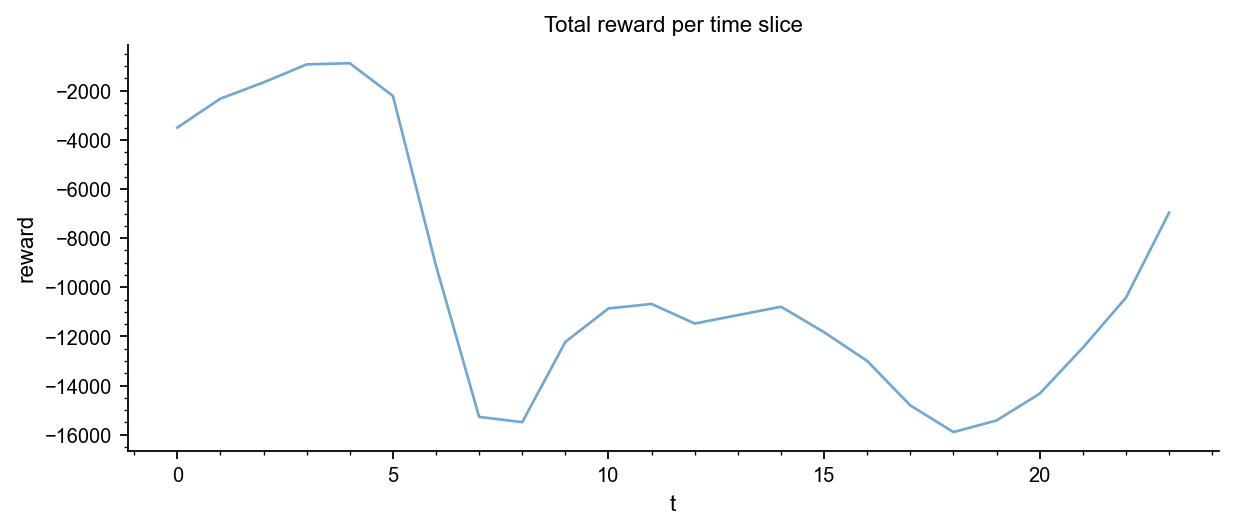

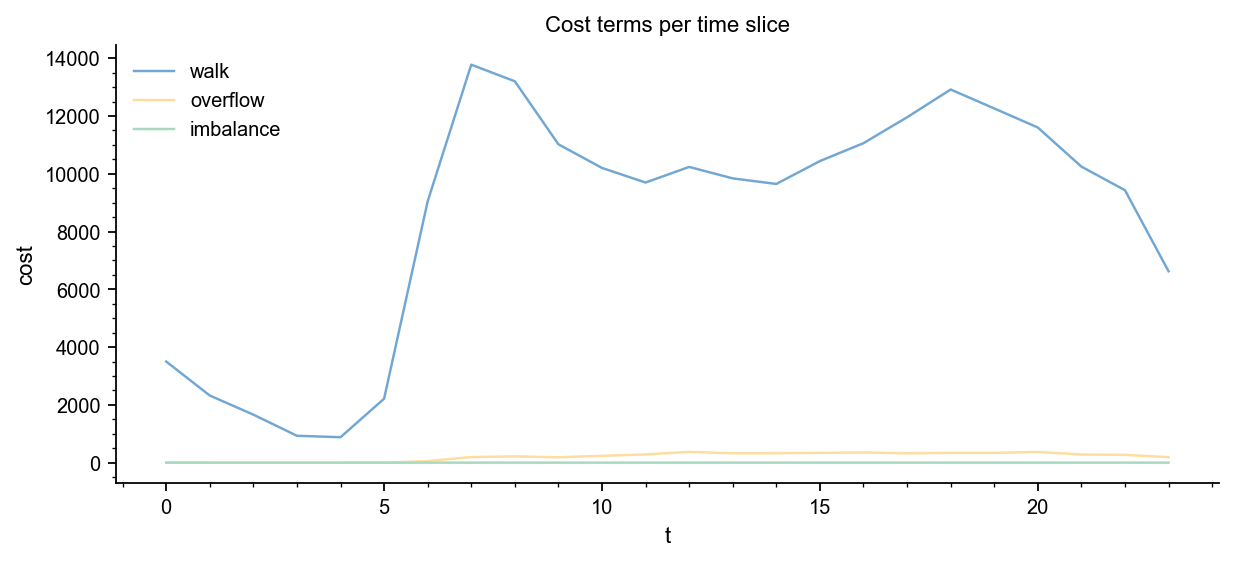

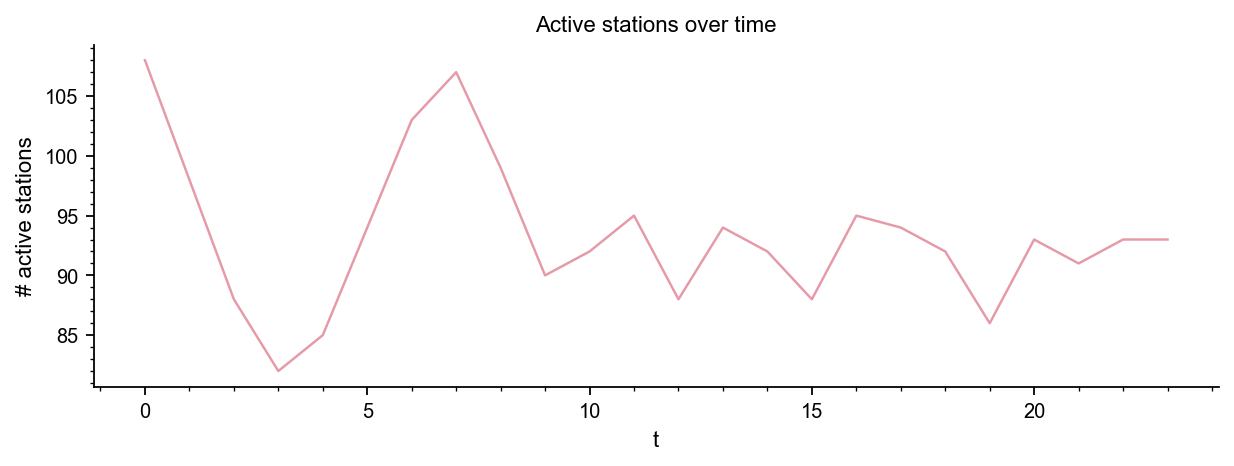

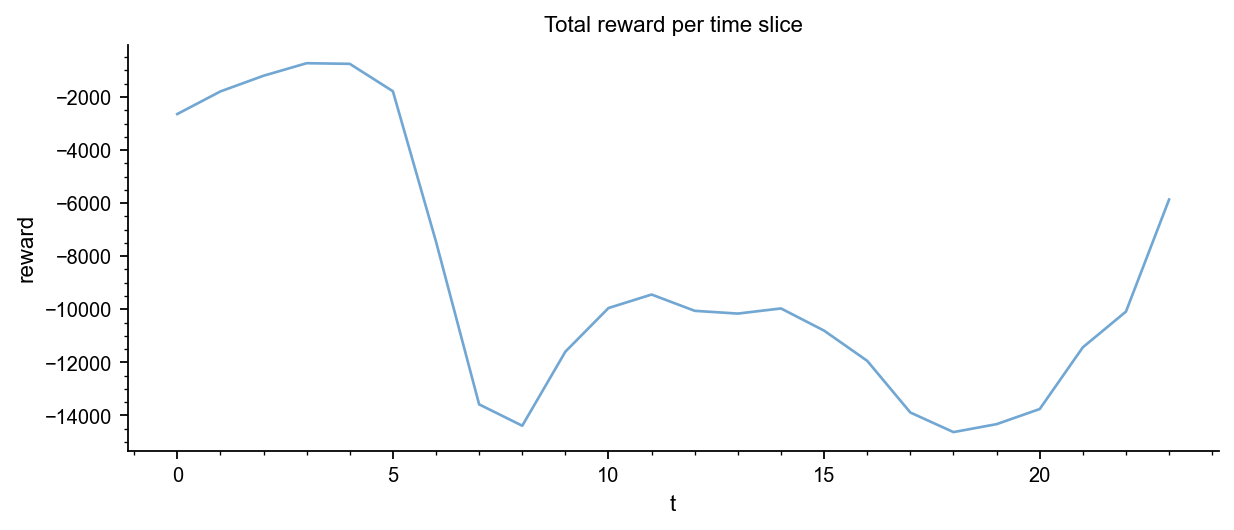

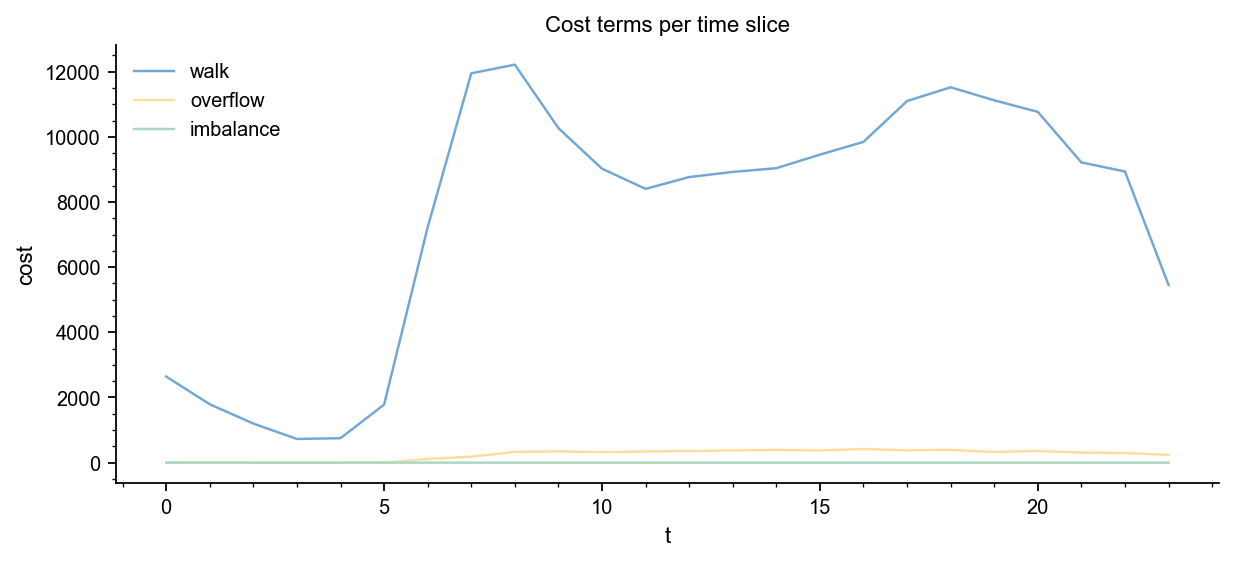

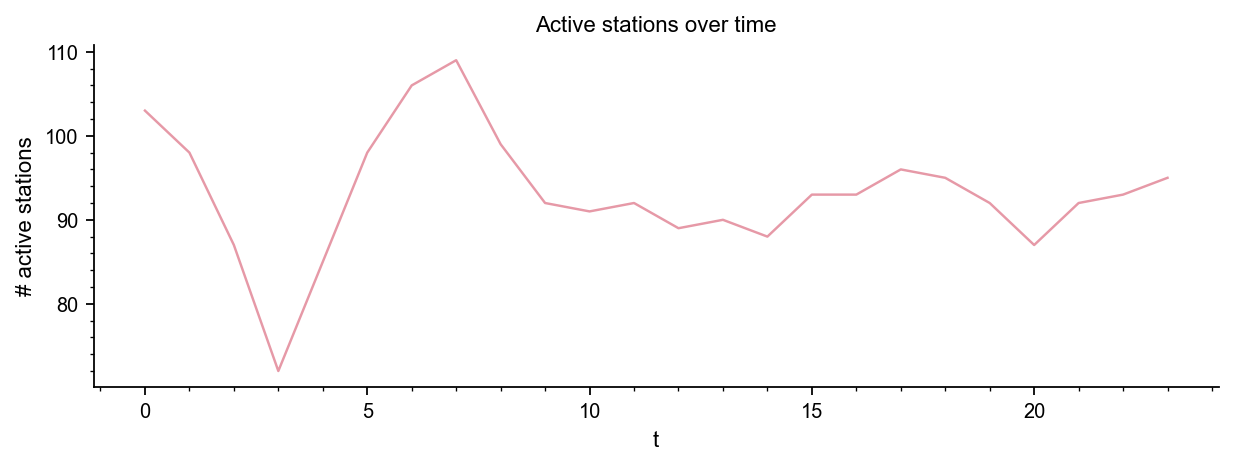

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.data_prep import load_data
from src.offline_model import random_search
from src.online_policy import LinUCB
from src.simulate import BikeEnv
from src.viz import set_journal_style, plot_online_curves

set_journal_style()


# 读取数据
D, Dist, cap, meta, stations = load_data("data/processed")

J_COUNT = len(meta["J_ids"])
I_COUNT = len(meta["I_ids"])
GRID_N = int(np.sqrt(I_COUNT))

# 先做一次离线选址（作为在线部分的固定站点集合 y_best）
BUDGET_MIN_RATIO = 0.40
BUDGET_MAX_RATIO = 0.80
budget_min = int(np.ceil(BUDGET_MIN_RATIO * J_COUNT))
budget_max = int(np.floor(BUDGET_MAX_RATIO * J_COUNT))
n_samples = int(8 * J_COUNT)

alpha_walk = 1.0
lam_over = 1.0
mu_imb = 1.0
eta_build = 0.6

best, _ = random_search(
    D, Dist, cap,
    budget_min=budget_min,
    budget_max=budget_max,
    n_samples=n_samples,
    alpha_walk=alpha_walk,
    lam_over=lam_over,
    mu_imb=mu_imb,
    eta_build=eta_build,
    normalize_terms=True,
    station_penalty_mode="minmax",
    station_penalty_power=2.0,
    rng_seed=42,
)

y_best = best["y"]
print("Offline best k:", int(y_best.sum()), "total:", best["total"])

# baseline: no policy（随机在最近 3 个站点里选）
env = BikeEnv(D, Dist, cap, y_best,
             alpha_walk=alpha_walk,
             lam_over=lam_over,
             mu_imb=mu_imb,
             rng_seed=0)
hist_baseline = env.run_episode(policy=None)
plot_online_curves(hist_baseline)

# LinUCB policy
dim = 5  # 与 build_feature_vector 保持一致
policy = LinUCB(dim=dim, alpha=1.0)
env2 = BikeEnv(D, Dist, cap, y_best,
              alpha_walk=alpha_walk,
              lam_over=lam_over,
              mu_imb=mu_imb,
              rng_seed=1)
hist_ucb = env2.run_episode(policy=policy)
plot_online_curves(hist_ucb)

# Compare different algorithms.
## k-median (in our strategy)
An algorithm that minimizes the sum of distances from each point to its nearest center, using the median as the cluster 

representative.

Ideal for applications where the goal is to minimize total travel cost or service distance, such as facility location for 

minimizing customer commute.
## k-supplier
An algorithm that aims to minimize the maximum distance a point has to its nearest center, with the constraint that 

centers must be chosen from a predefined set of candidate locations.

Suited for scenarios where facility locations are restricted, like placing emergency stations only in certain existing 

buildings.
## k-center
An algorithm that seeks to minimize the maximum distance from any point to its nearest center, effectively minimizing the 

worst-case service radius.

Perfect for critical applications requiring a guaranteed service level for all points, such as placing fire stations to 

ensure quick response times anywhere in a city.

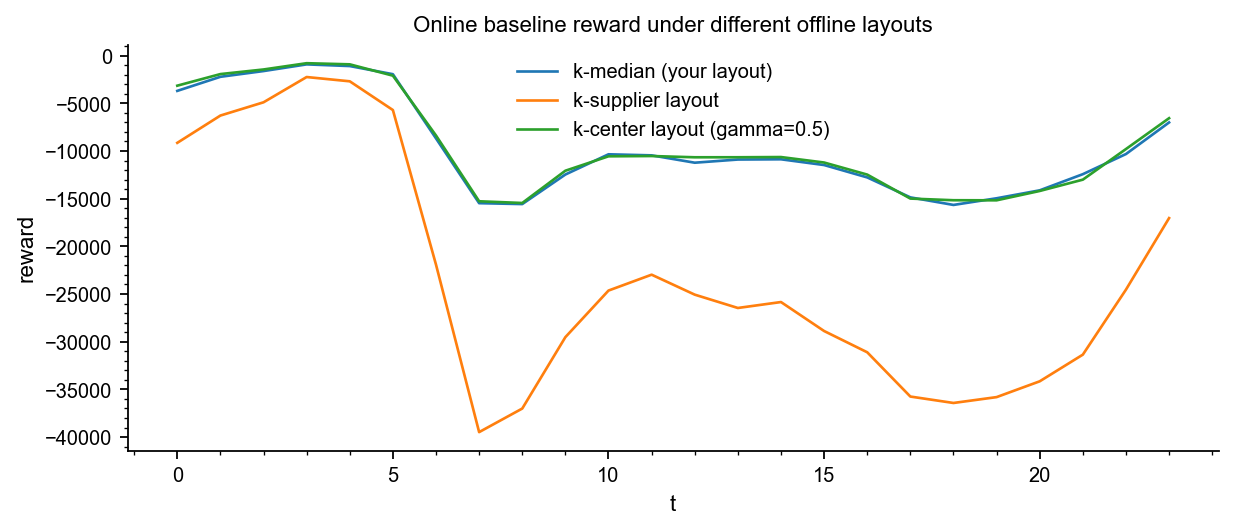

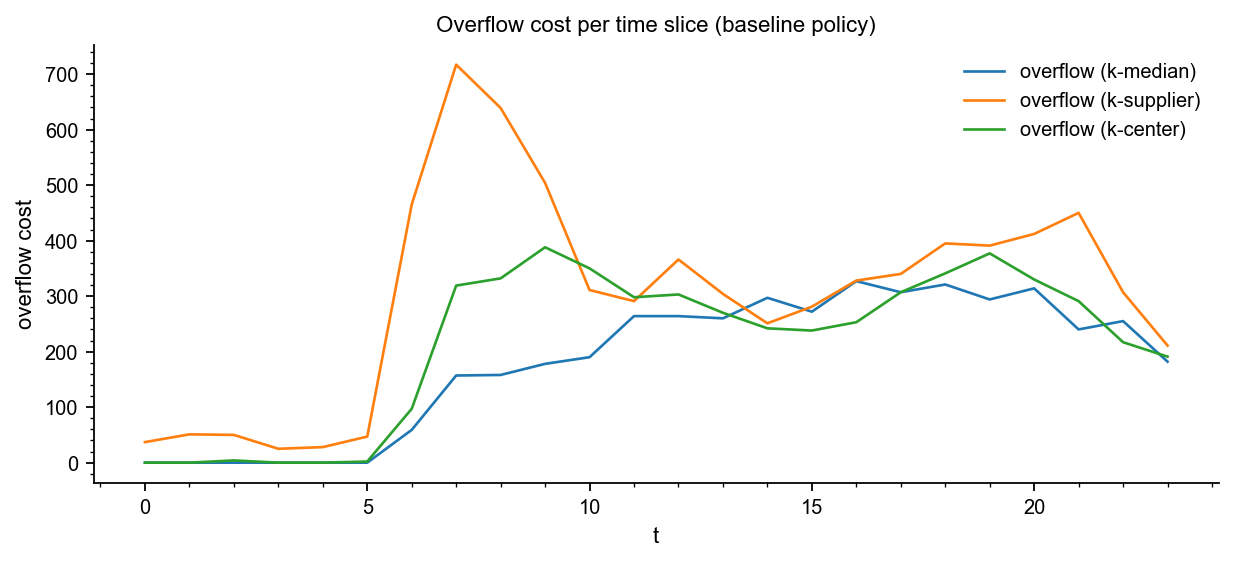

In [2]:
# =========================================================
# 4) (Optional) Compare ONLINE curves under different OFFLINE layouts
#    This keeps your original demo intact and adds a side-by-side baseline.
# =========================================================
from src.offline_model import greedy_kcenter, greedy_ksupplier

k = int(y_best.sum())
y_ksupplier = greedy_ksupplier(D, Dist, k, seed=0)
y_kcenter = greedy_kcenter(D, Dist, k, seed=0, gamma=0.5)

def run_baseline(y_layout, seed):
    env = BikeEnv(D, Dist, cap, y_layout,
                 alpha_walk=alpha_walk,
                 lam_over=lam_over,
                 mu_imb=mu_imb,
                 rng_seed=seed)
    return env.run_episode(policy=None)

hist_kmedian = run_baseline(y_best, seed=10)
hist_ksupplier = run_baseline(y_ksupplier, seed=11)
hist_kcenter = run_baseline(y_kcenter, seed=12)

import numpy as np
import matplotlib.pyplot as plt

t = np.arange(len(hist_kmedian["total_reward"]))
plt.figure(figsize=(7.6, 3.2))
plt.plot(t, hist_kmedian["total_reward"], label="k-median (your layout)")
plt.plot(t, hist_ksupplier["total_reward"], label="k-supplier layout")
plt.plot(t, hist_kcenter["total_reward"], label="k-center layout (gamma=0.5)")
plt.xlabel("t")
plt.ylabel("reward")
plt.title("Online baseline reward under different offline layouts")
plt.legend()
plt.show()

plt.figure(figsize=(7.6, 3.4))
plt.plot(t, hist_kmedian["overflow_cost"], label="overflow (k-median)")
plt.plot(t, hist_ksupplier["overflow_cost"], label="overflow (k-supplier)")
plt.plot(t, hist_kcenter["overflow_cost"], label="overflow (k-center)")
plt.xlabel("t")
plt.ylabel("overflow cost")
plt.title("Overflow cost per time slice (baseline policy)")
plt.legend()
plt.show()


# See the stations in different times!
## Different color indicates different ideal existing capacity
Red: very high, capacity > 0.9 highest capacity

Yellow: medium, 0.66 highest capacity < capacity < 0.90 highest capacity

Green: low, 0.1 highest capacity < capacity < 0.66 highest capacity

Blue: extremely low or not activated, capacity < 0.1 highest capacity
## Different size indicates different highest capacity
Larger the dot size, higher the shared bike capacity

/Users/guozhenning/Desktop/VSCodeProjects/CTProject/src/viz.py:560: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


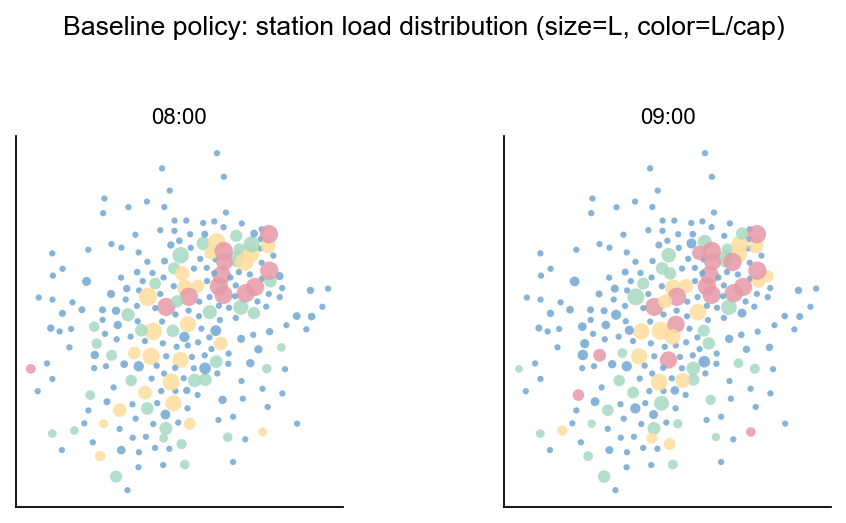

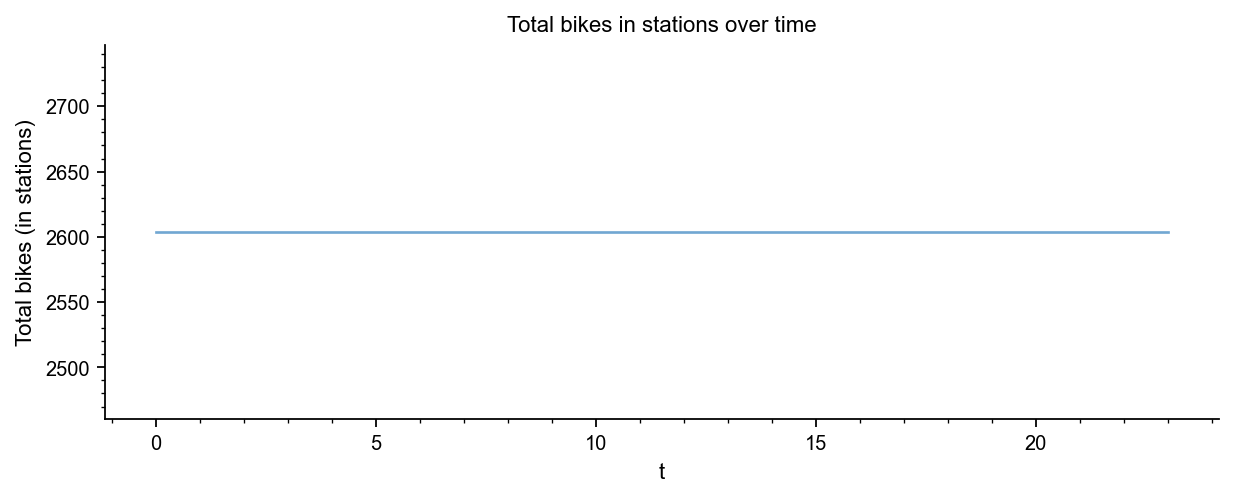

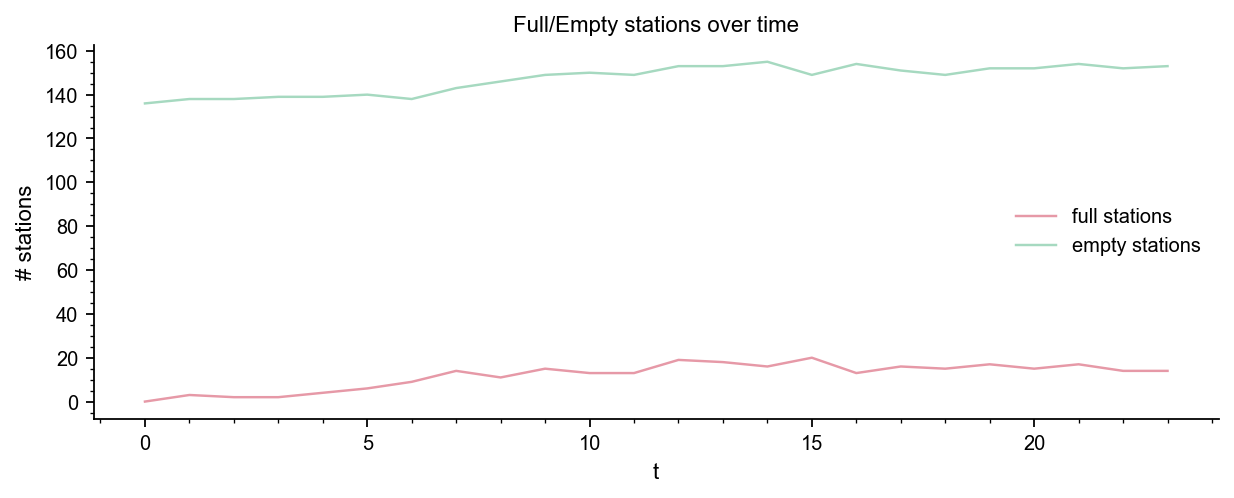

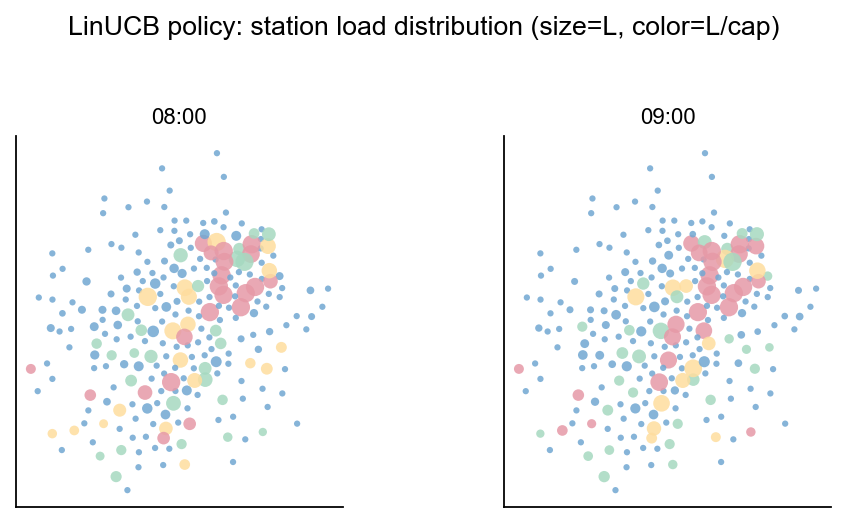

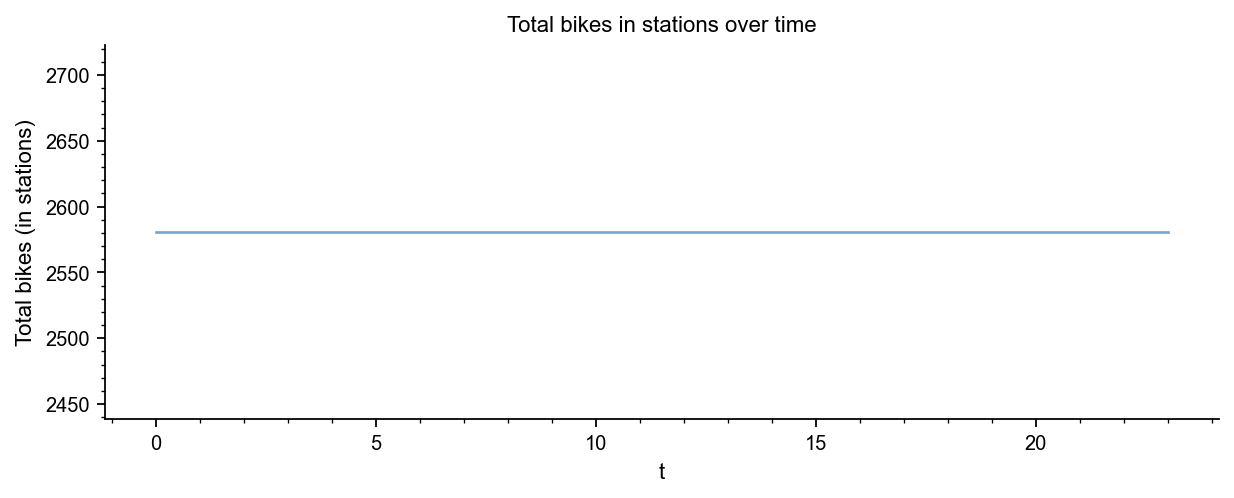

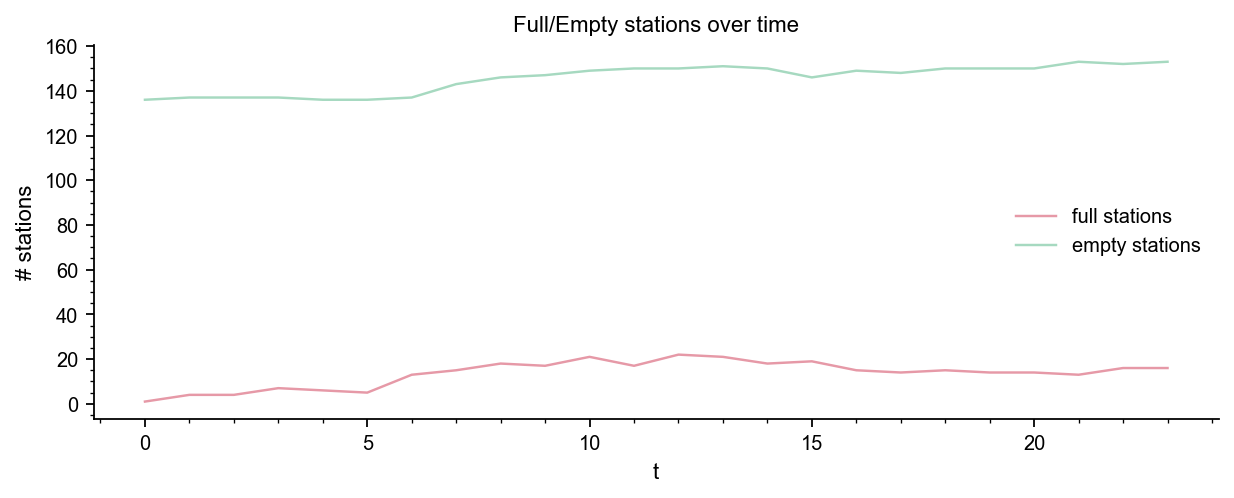

In [4]:
# =========================================================
# 5) Station-level distributions across time
#    If you haven't run the cells above (or they errored), this cell will
#    (re)compute what it needs WITHOUT changing your original demo logic.
# =========================================================
import numpy as np
from src.data_prep import load_data
from src.offline_model import random_search
from src.online_policy import LinUCB
from src.simulate import BikeEnv
from src.viz import plot_station_distribution_panels, plot_bike_stock_summary

def _ensure_online_histories():
    global D, Dist, cap, meta, stations
    global y_best, alpha_walk, lam_over, mu_imb, eta_build
    global hist_baseline, hist_ucb

    # 1) Data
    if "D" not in globals() or "Dist" not in globals() or "cap" not in globals() or "stations" not in globals():
        D, Dist, cap, meta, stations = load_data("data/processed")

    # 2) Weights (match your demo defaults if not already defined)
    alpha_walk = globals().get("alpha_walk", 1.0)
    lam_over   = globals().get("lam_over", 1.0)
    mu_imb     = globals().get("mu_imb", 1.0)
    eta_build  = globals().get("eta_build", 0.6)

    # 3) Offline layout (y_best)
    if "y_best" not in globals():
        J_COUNT = len(meta["J_ids"])
        budget_min = int(np.ceil(0.40 * J_COUNT))
        budget_max = int(np.floor(0.80 * J_COUNT))
        best, _ = random_search(
            D, Dist, cap,
            budget_min=budget_min,
            budget_max=budget_max,
            n_samples=200,
            alpha_walk=alpha_walk,
            lam_over=lam_over,
            mu_imb=mu_imb,
            eta_build=eta_build,
            rng_seed=0,
        )
        y_best = best["y"]

    # 4) Baseline episode
    if "hist_baseline" not in globals() or "L_hist" not in globals().get("hist_baseline", {}):
        env = BikeEnv(D, Dist, cap, y_best,
                      alpha_walk=alpha_walk, lam_over=lam_over, mu_imb=mu_imb, rng_seed=0)
        hist_baseline = env.run_episode(policy=None)

    # 5) LinUCB episode
    if "hist_ucb" not in globals() or "L_hist" not in globals().get("hist_ucb", {}):
        dim = 5  # must match build_feature_vector
        policy = LinUCB(dim=dim, alpha=1.0)
        env2 = BikeEnv(D, Dist, cap, y_best,
                       alpha_walk=alpha_walk, lam_over=lam_over, mu_imb=mu_imb, rng_seed=1)
        hist_ucb = env2.run_episode(policy=policy)

_ensure_online_histories()

# Choose a few representative time slices (e.g., morning/noon/evening/night)
#times_show = (0, 1, 2, 3, 4, 5)
#times_show = (6, 7, 8, 9, 10, 11)
#times_show = (12, 13, 14, 15, 16, 17)
#times_show = (18, 19, 20, 21, 22, 23)
times_show = (8,9)

# --- Baseline ---
if "L_hist" not in hist_baseline:
    raise RuntimeError("history does not contain 'L_hist'. Please ensure your BikeEnv records station-level load each time slice.")
L_base = np.stack(hist_baseline["L_hist"], axis=0)
plot_station_distribution_panels(
    stations_df=stations, cap=cap, L_hist=L_base, times=times_show,
    title="Baseline policy: station load distribution (size=L, color=L/cap)"
)
plot_bike_stock_summary(hist_baseline)

# --- LinUCB ---
if "L_hist" not in hist_ucb:
    raise RuntimeError("history does not contain 'L_hist'. Please ensure your BikeEnv records station-level load each time slice.")
L_ucb = np.stack(hist_ucb["L_hist"], axis=0)
plot_station_distribution_panels(
    stations_df=stations, cap=cap, L_hist=L_ucb, times=times_show,
    title="LinUCB policy: station load distribution (size=L, color=L/cap)"
)
plot_bike_stock_summary(hist_ucb)
